In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


## _Prepration_

In [2]:
# Imports Modules

import os
import sys
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scipy
import missingno as msno
import colorama
from colorama import Fore, Back, Style
%matplotlib inline
import gc
warnings.filterwarnings("ignore")
!pip install feature_engine
from feature_engine.encoding import WoEEncoder



# Tools
from sklearn.preprocessing import LabelEncoder, power_transform, OneHotEncoder,StandardScaler,minmax_scale ,MinMaxScaler ,RobustScaler
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline




# Libraries
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report,log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier , RandomForestClassifier , ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV ,GroupKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Clone Repoes
!git clone https://github.com/analokmaus/kuma_utils.git
sys.path.append("kuma_utils/")
from kuma_utils.preprocessing.imputer import LGBMImputer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 494.1 kB/s eta 0:00:00


Cloning into 'kuma_utils'...
remote: Enumerating objects: 915, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 915 (delta 104), reused 102 (delta 96), pack-reused 795
Receiving objects: 100% (915/915), 679.99 KiB | 967.00 KiB/s, done.
Resolving deltas: 100% (592/592), done.


In [3]:
gc.enable

<function gc.enable()>

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize(# _Data Import_

In [4]:
train_df = pd.read_csv("/kaggle/input/tabular-playground-series-aug-2022/train.csv")
train_df.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [5]:
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/test.csv')
test_df.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
3,26573,F,112.72,material_5,material_6,6,4,8,11,10,...,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
4,26574,F,208.00,material_5,material_6,6,4,14,16,8,...,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044


# _Data Analyze_

In [6]:
all_features = train_df.drop(['id', 'failure'],axis=1).columns.tolist()
print(all_features, end='')

['product_code', 'loading', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']

In [7]:
def get_continuous_columns(dataframe,verbose=True):
    """
    Use this function to retun countinous  columns of a dataframe
    input : dataframe
    output: list 
    
    """
    
    continuos_column = []
    for column in dataframe.columns:
        if dataframe.dtypes[column] in ['float16' ,'float32' ,'float64']:
            continuos_column.append(column)
    print(f'There are {len(continuos_column)} continous  columns  in Datframe')
    print(continuos_column,end="")
    print("\n")
    return continuos_column

In [8]:
def get_categorical_columns(dataframe,verbose=True):
    """
    Use this function to retun categorical columns of a dataframe
    input : dataframe
    output: list 
    
    """
    categorical_columns = []
    for column in dataframe.columns :
        if dataframe.dtypes[column] in ['int8' ,'int16',"int32" ,"int64" ,'uint8']:
            categorical_columns.append(column)
    print(f' There are {len(categorical_columns)} categorical columns in Dataframe',end='')
    print(categorical_columns,end='')
    print("\n")
    return categorical_columns

In [9]:
def get_object_columns(dataframe,verbose=True):
    """
    Use this function to retun object columns of a dataframe
    input : dataframe
    output: list 
    
    """
    object_columns = []
    for column in dataframe.columns :
        if dataframe.dtypes[column] in ['object']:
            object_columns.append(column)
    print(f' There are {len(object_columns)} Objective columns in Dataframe',end='')
    print(object_columns,end='')
    print("\n")
    return object_columns

In [10]:
# Identify Categorial Columns
cat_columns = get_categorical_columns(train_df[all_features])

 There are 5 categorical columns in Dataframe['attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2']



In [11]:
# Identify Continuos Columns
cont_columns = get_continuous_columns(train_df[all_features])

There are 16 continous  columns  in Datframe
['loading', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']



In [12]:
# Identify Objective Columns
obj_columns = get_object_columns(train_df[all_features])

 There are 3 Objective columns in Dataframe['product_code', 'attribute_0', 'attribute_1']



In [13]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,26570.0,13284.500000,7670.242662,0.000,6642.25000,13284.5000,19926.75000,26569.000
loading,26320.0,127.826233,39.030020,33.160,99.98750,122.3900,149.15250,385.860
attribute_2,26570.0,6.754046,1.471852,5.000,6.00000,6.0000,8.00000,9.000
attribute_3,26570.0,7.240459,1.456493,5.000,6.00000,8.0000,8.00000,9.000
measurement_0,26570.0,7.415883,4.116690,0.000,4.00000,7.0000,10.00000,29.000
measurement_1,26570.0,8.232518,4.199401,0.000,5.00000,8.0000,11.00000,29.000
measurement_2,26570.0,6.256568,3.309109,0.000,4.00000,6.0000,8.00000,24.000
measurement_3,26189.0,17.791528,1.001200,13.968,17.11700,17.7870,18.46900,21.499
measurement_4,26032.0,11.731988,0.996085,8.008,11.05100,11.7330,12.41000,16.484
measurement_5,25894.0,17.127804,0.996414,12.073,16.44300,17.1320,17.80500,21.425


In [14]:
# Missing Rates
def missing_rate(data_frame):
    missing_rate = {}
    for col in data_frame.columns:
        column_missing_rate = data_frame[col].isna().sum() / len(data_frame[col]) * 100
        missing_rate[col] = round(column_missing_rate,2)
    missing_rate = pd.DataFrame(missing_rate.items(), index=None)
    return missing_rate

In [15]:
missing_rate_train = missing_rate(train_df)

In [16]:
missing_rate_test = missing_rate(test_df)

In [17]:
pd.concat([missing_rate_train[0].rename("Features"),missing_rate_train[1].rename("Train Mssing rate"),missing_rate_test[1].rename("Test Missing Rate")],axis=1)

,Features,Train Mssing rate,Test Missing Rate
0,id,0.00,0.00
1,product_code,0.00,0.00
2,loading,0.94,1.07
3,attribute_0,0.00,0.00
4,attribute_1,0.00,0.00
5,attribute_2,0.00,0.00
6,attribute_3,0.00,0.00
7,measurement_0,0.00,0.00
8,measurement_1,0.00,0.00
9,measurement_2,0.00,0.00


In [18]:
measurment_missings = pd.concat([train_df[cont_columns].isna().sum().rename('missing values in train'),
           round(train_df[cont_columns].isna().sum() / len(train_df[cont_columns]) * 100,2).rename("Missin Rate Train"),
           test_df[cont_columns].isna().sum().rename('missing values in test'),
          round(test_df[cont_columns].isna().sum() / len(test_df[cont_columns]) * 100,2).rename("Missin Rate Test")],
          axis=1)
measurment_missings

,missing values in train,Missin Rate Train,missing values in test,Missin Rate Test
loading,250,0.94,223,1.07
measurement_3,381,1.43,329,1.58
measurement_4,538,2.02,409,1.97
measurement_5,676,2.54,508,2.45
measurement_6,796,3.00,624,3.00
measurement_7,937,3.53,720,3.47
measurement_8,1048,3.94,846,4.07
measurement_9,1227,4.62,904,4.35
measurement_10,1300,4.89,1067,5.14
measurement_11,1468,5.53,1136,5.47


In [19]:
cardinality_train = train_df[obj_columns + cat_columns].nunique()
cardinality_train

product_code      5
attribute_0       2
attribute_1       3
attribute_2       4
attribute_3       4
measurement_0    29
measurement_1    30
measurement_2    25
dtype: int64

In [20]:
cardinality_test = train_df[obj_columns + cat_columns].nunique()
cardinality_test

product_code      5
attribute_0       2
attribute_1       3
attribute_2       4
attribute_3       4
measurement_0    29
measurement_1    30
measurement_2    25
dtype: int64

In [21]:
data_cardinality = pd.concat([pd.DataFrame(cardinality_train.rename("Train Cardinality")),pd.DataFrame(cardinality_test.rename("Test Cardinality"))],axis=1)
data_cardinality

,Train Cardinality,Test Cardinality
product_code,5,5
attribute_0,2,2
attribute_1,3,3
attribute_2,4,4
attribute_3,4,4
measurement_0,29,29
measurement_1,30,30
measurement_2,25,25


# _EDA_

<AxesSubplot:xlabel='failure', ylabel='Count'>

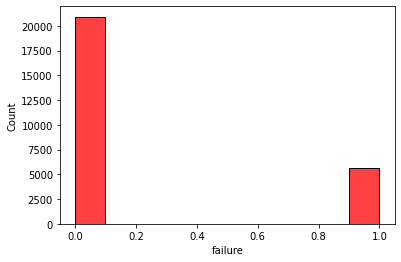

In [22]:
# Distrbution of Failure
sns.histplot(data=train_df['failure'],palette="viridis",bins=10,color="red")


In [23]:
# Percenatege of Failure
target_pecentage = pd.DataFrame(train_df['failure'].value_counts() / len(train_df.failure))
target_pecentage.T

,0,1
failure,0.787392,0.212608


Text(0.5, 1.0, 'Target distribution')

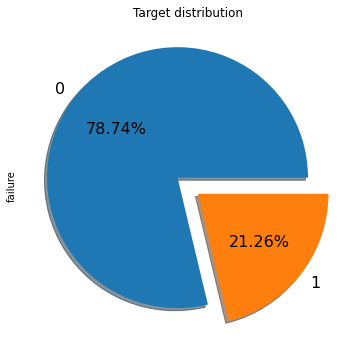

In [24]:
plt.figure(figsize=(6,6))
train_df['failure'].value_counts().plot.pie(explode=[0.10,0.1], autopct='%1.2f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

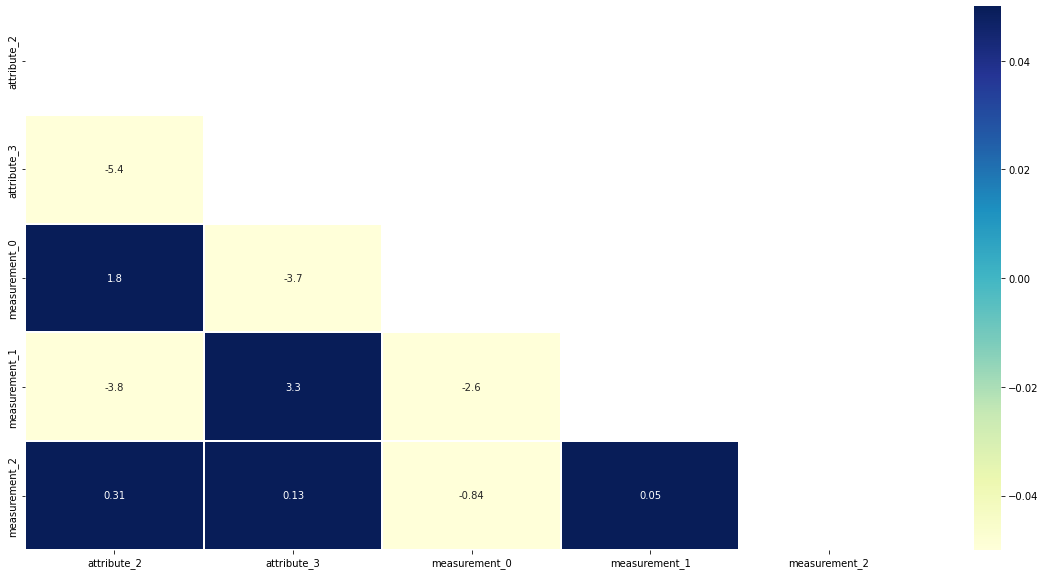

In [25]:
# Categorial Corrilation
matrix = np.triu(train_df[cat_columns].corr())
plt.figure(figsize=(20 ,10))
sns.heatmap(train_df[cat_columns].corr() * 10 , annot= True , cmap="YlGnBu" , mask=matrix , linecolor="white" ,cbar=True ,vmin= - 0.05  , vmax= 0.05 ,linewidths=0.1)
plt.show()

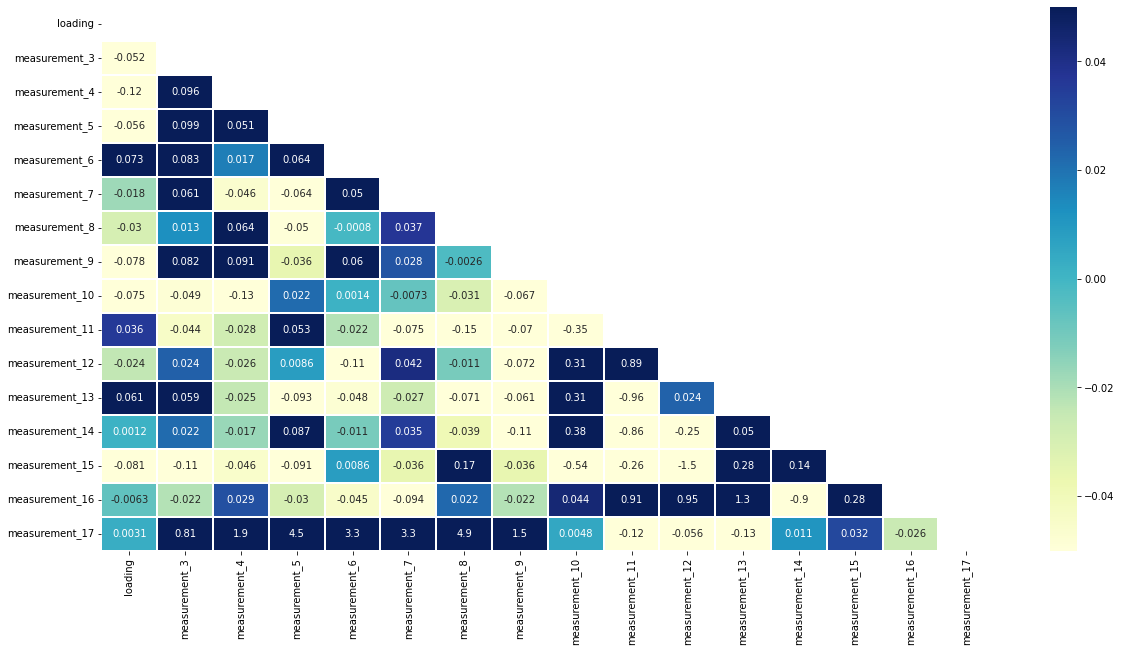

In [26]:
# Continous columns Corrilation

matrix = np.triu(train_df[cont_columns].corr())
plt.figure(figsize=(20 ,10))
sns.heatmap(train_df[cont_columns].corr() * 10, annot= True , cmap="YlGnBu" , mask=matrix , linecolor="white" ,cbar=True ,vmin= - 0.05  , vmax= 0.05 ,linewidths=0.1)
plt.show()

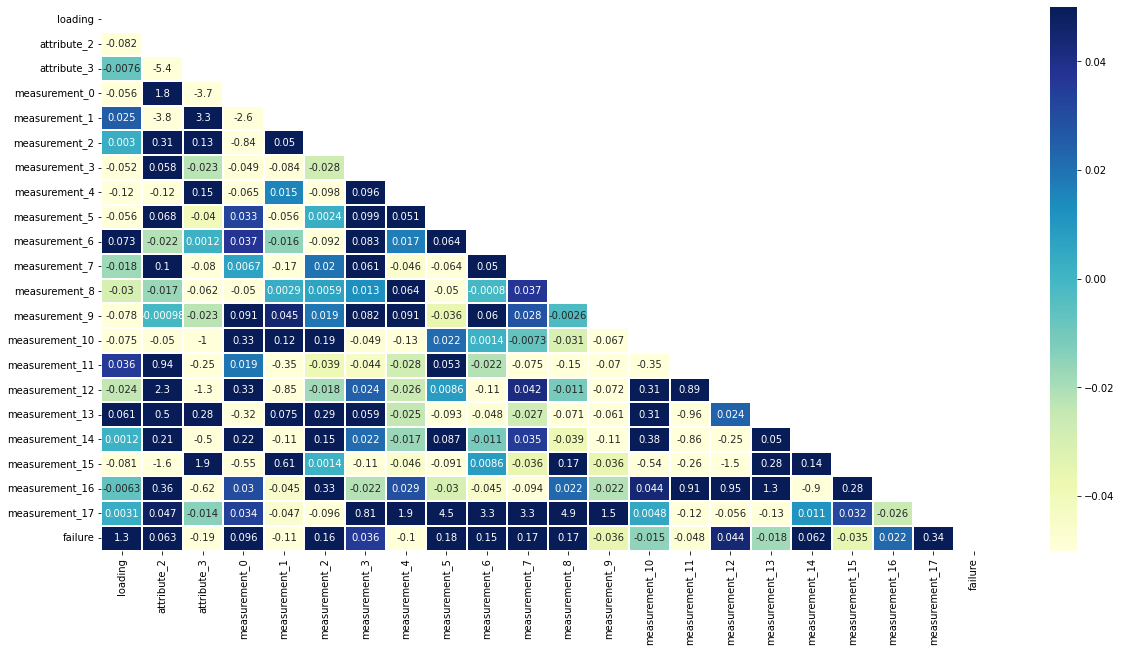

In [27]:
# All Feautre Corr
matrix = np.triu(train_df.drop("id" , axis=1).corr())
plt.figure(figsize=(20 ,10))
sns.heatmap(train_df.drop("id", axis=1).corr() * 10 , annot= True , cmap="YlGnBu" , mask=matrix , linecolor="white" ,cbar=True ,vmin= - 0.05  , vmax= 0.05 ,linewidths=0.1)
plt.show()

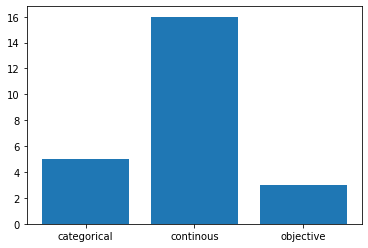

In [28]:
plt.bar([1,2,3], [len(cat_columns) ,len(cont_columns),len(obj_columns)])
plt.xticks([1,2,3] , ['categorical' , 'continous','objective'])
plt.show()

In [29]:
%%time
train_df.shape , test_df.shape

CPU times: user 27 µs, sys: 6 µs, total: 33 µs
Wall time: 37.4 µs


((26570, 26), (20775, 25))

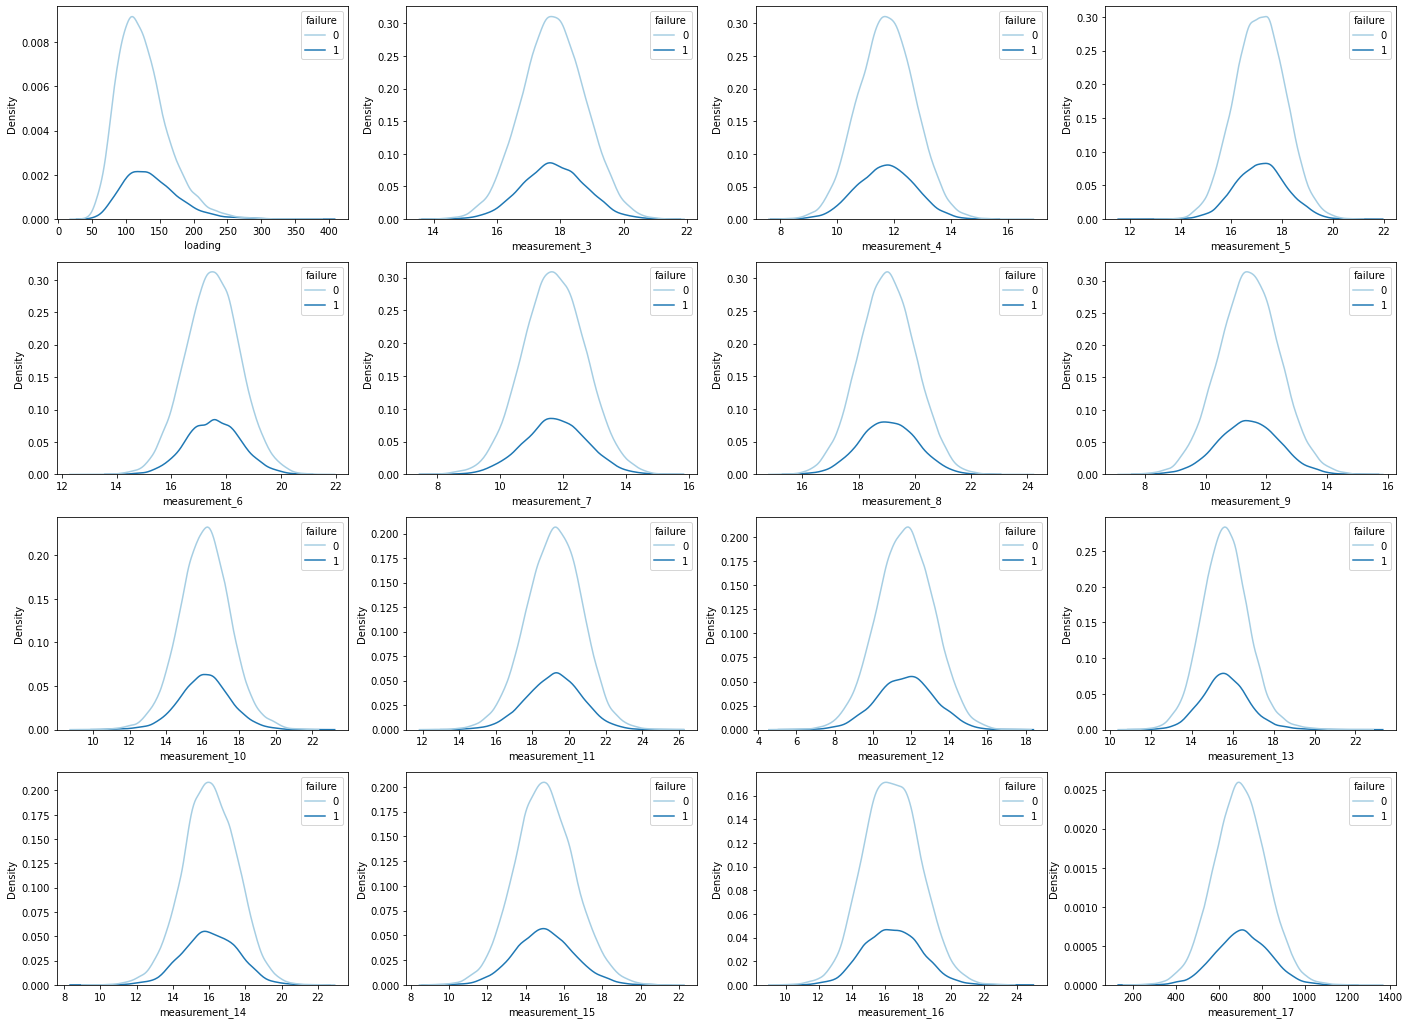

In [30]:
fig, axes = plt.subplots(figsize=(24,18))
for n,feature in enumerate(cont_columns):
    plt.subplot(4,4,n+1)
    sns.kdeplot(data=train_df,x=feature,hue="failure",palette=sns.color_palette("Paired",2))

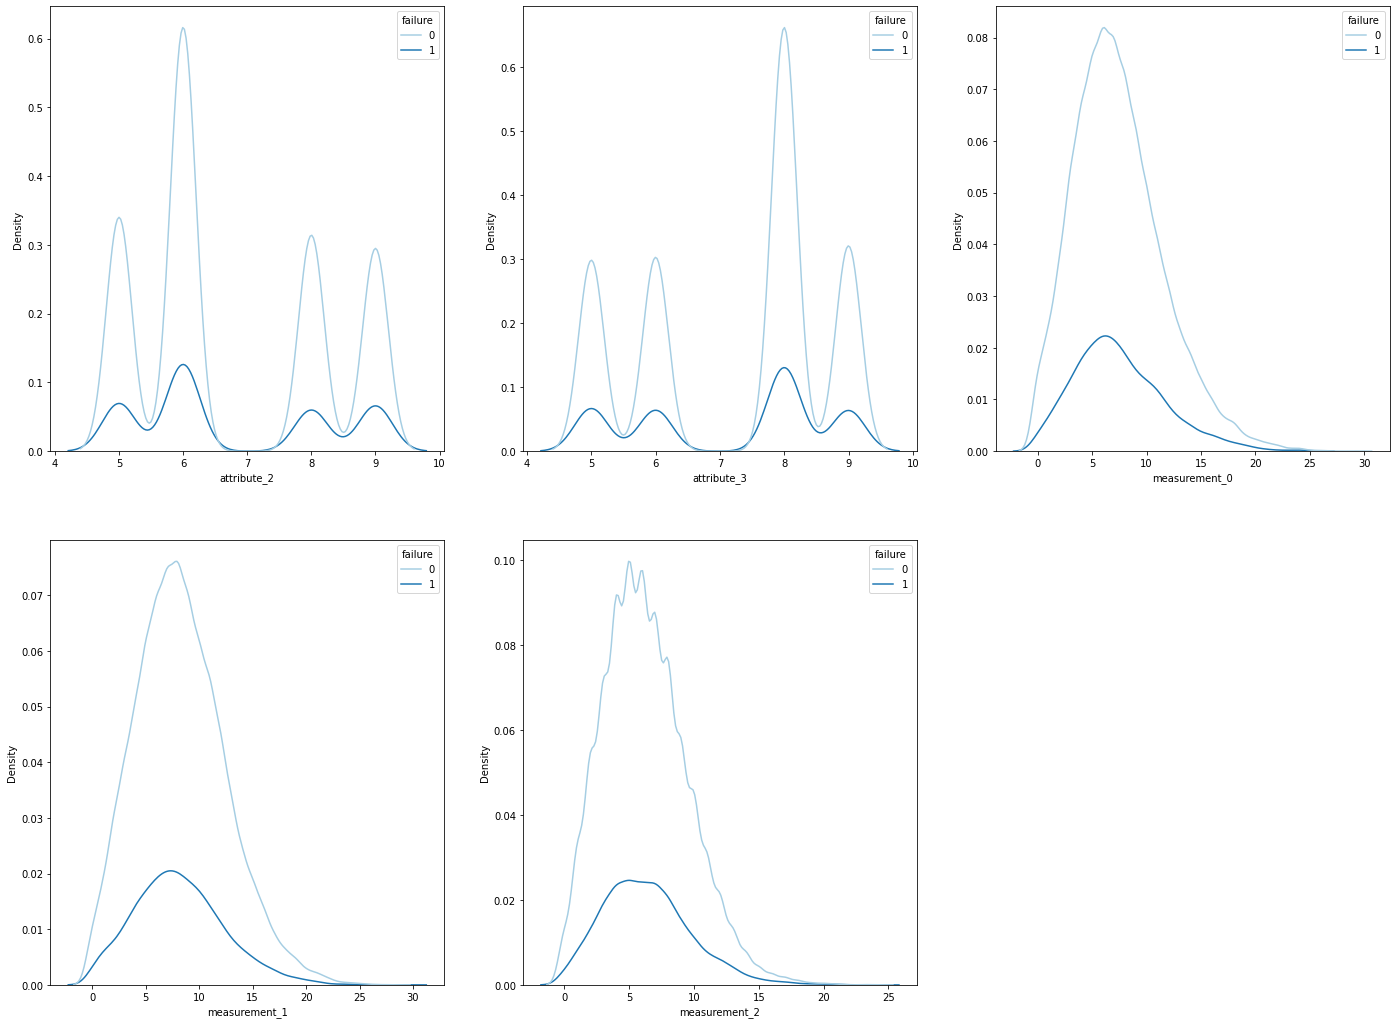

In [31]:
fig, axes = plt.subplots(figsize=(24,18))
for n,feature in enumerate(cat_columns):
    plt.subplot(2,3,n+1)
    sns.kdeplot(data=train_df,x=feature,hue="failure",palette=sns.color_palette("Paired",2))

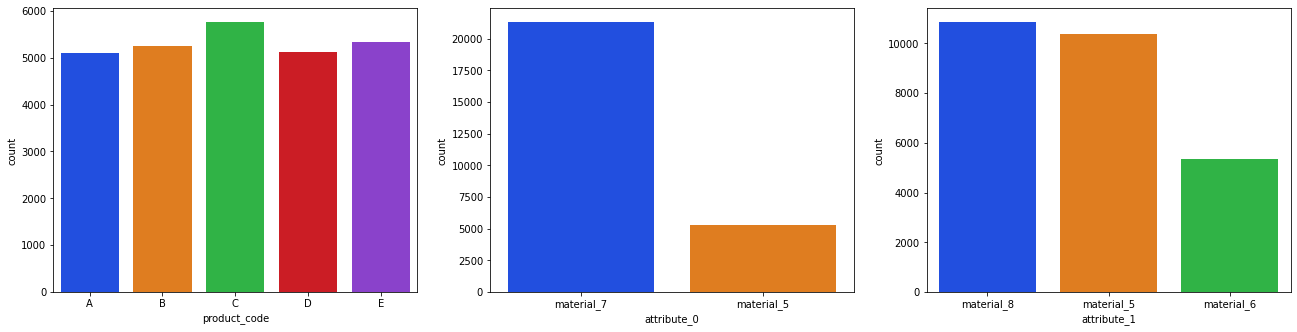

In [32]:
fig, axes = plt.subplots(figsize=(30,24))
for n,feature in enumerate(obj_columns):
    plt.subplot(4,4,n+1)
    sns.countplot(data=train_df,x=feature,palette=sns.color_palette("bright"))

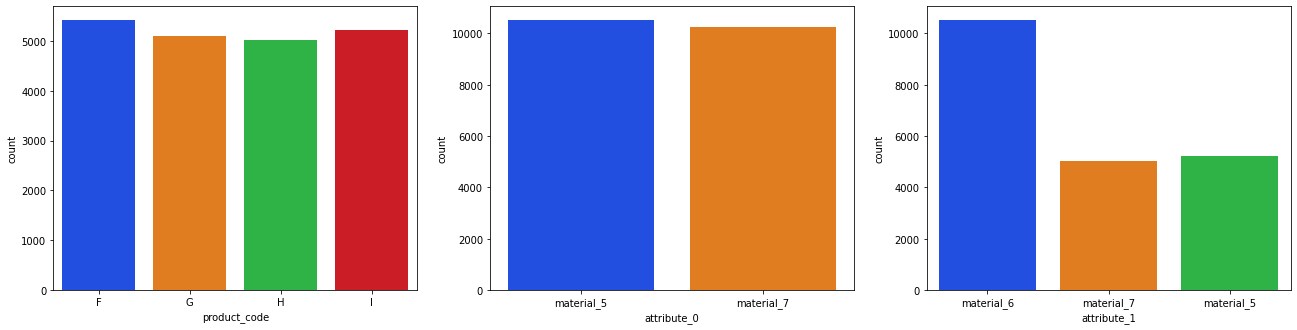

In [33]:
fig, axes = plt.subplots(figsize=(30,24))
for n,feature in enumerate(obj_columns):
    plt.subplot(4,4,n+1)
    sns.countplot(data=test_df,x=feature,palette=sns.color_palette("bright",))

# Compare Train and Test

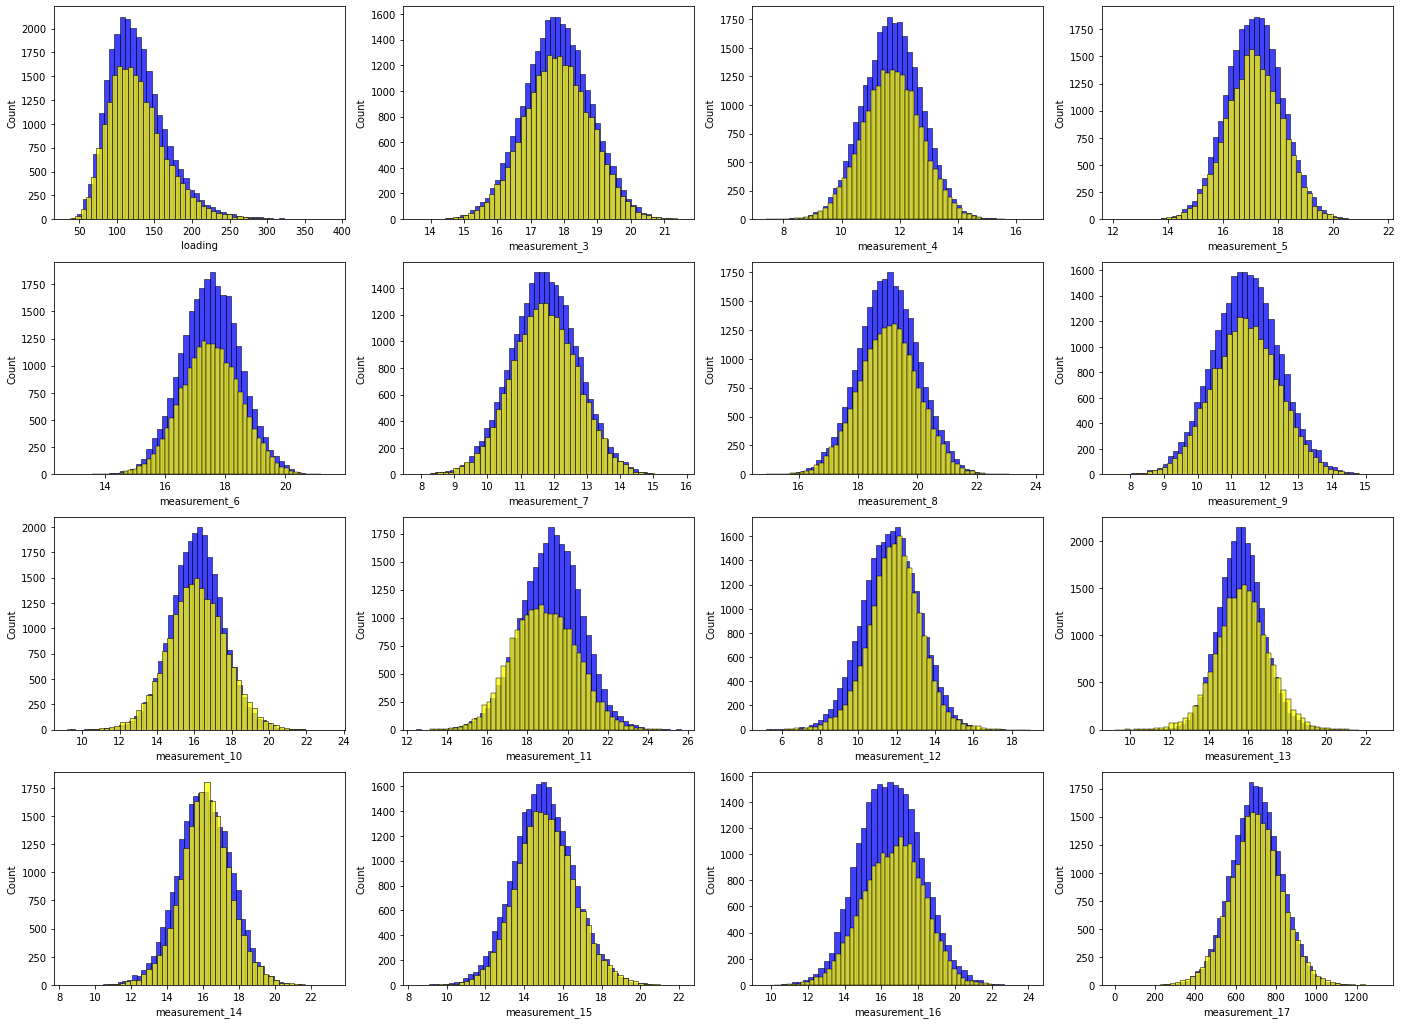

In [34]:
fig, axes = plt.subplots(figsize=(24,18))
for n,feature in enumerate(cont_columns):
    plt.subplot(4,4,n+1)
    sns.histplot(data=train_df,x=feature,color='blue',label="train",bins=50,palette="bright")
    sns.histplot(data=test_df,x=feature,color='yellow',label="train",bins=50,palette="bright")

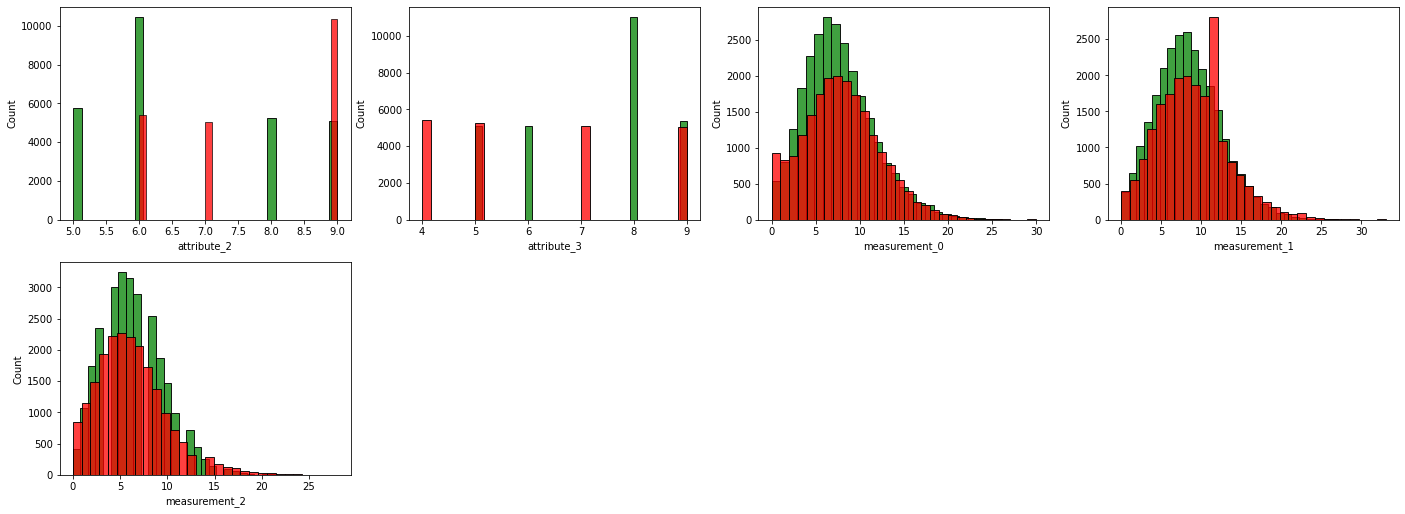

In [35]:
fig, axes = plt.subplots(figsize=(24,18))
for n,feature in enumerate(cat_columns):
    plt.subplot(4,4,n+1)
    sns.histplot(data=train_df,x=feature,color='green',label="train",bins=30,palette="paired")
    sns.histplot(data=test_df,x=feature,color='red',label="train",bins=30,palette="paired")

<AxesSubplot:>

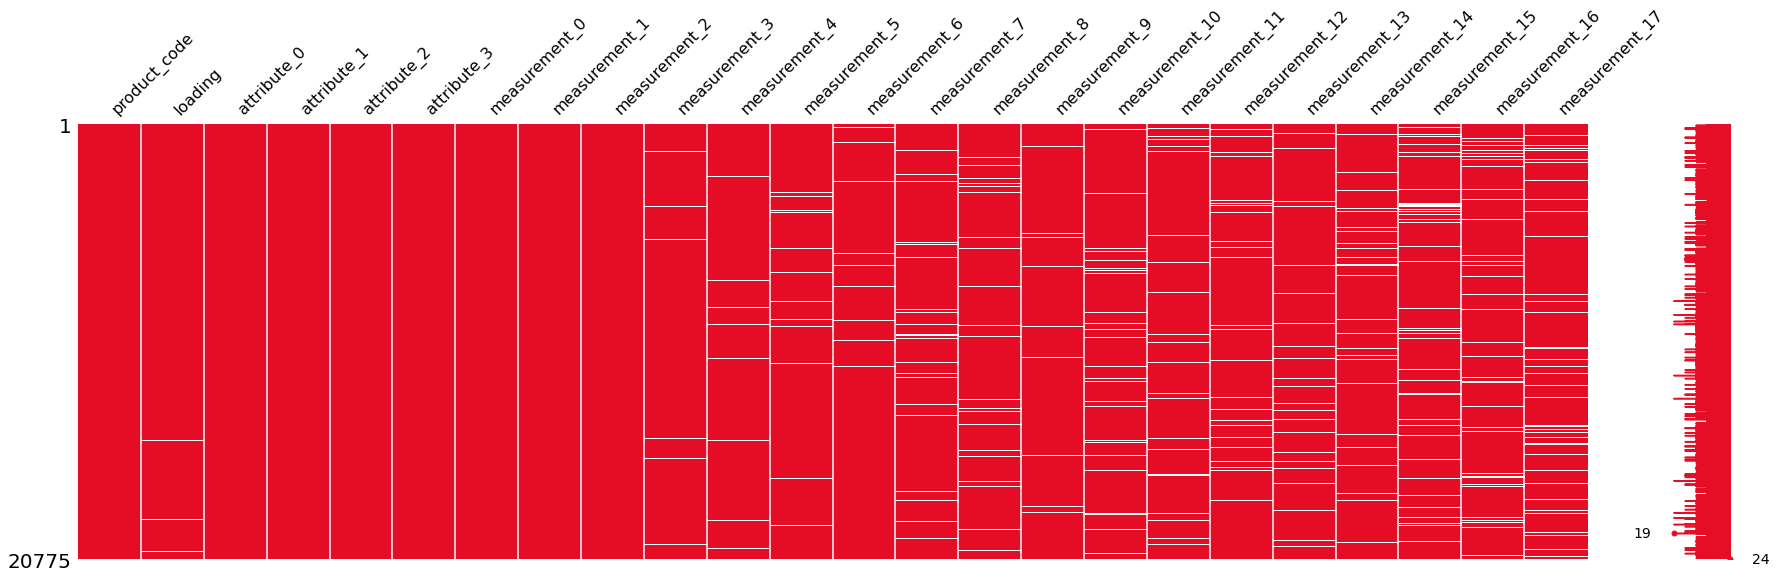

In [36]:
# Test Null Values
msno.matrix(test_df[all_features], color=(0.9, 0.05, 0.15), figsize=(30, 8))

<AxesSubplot:>

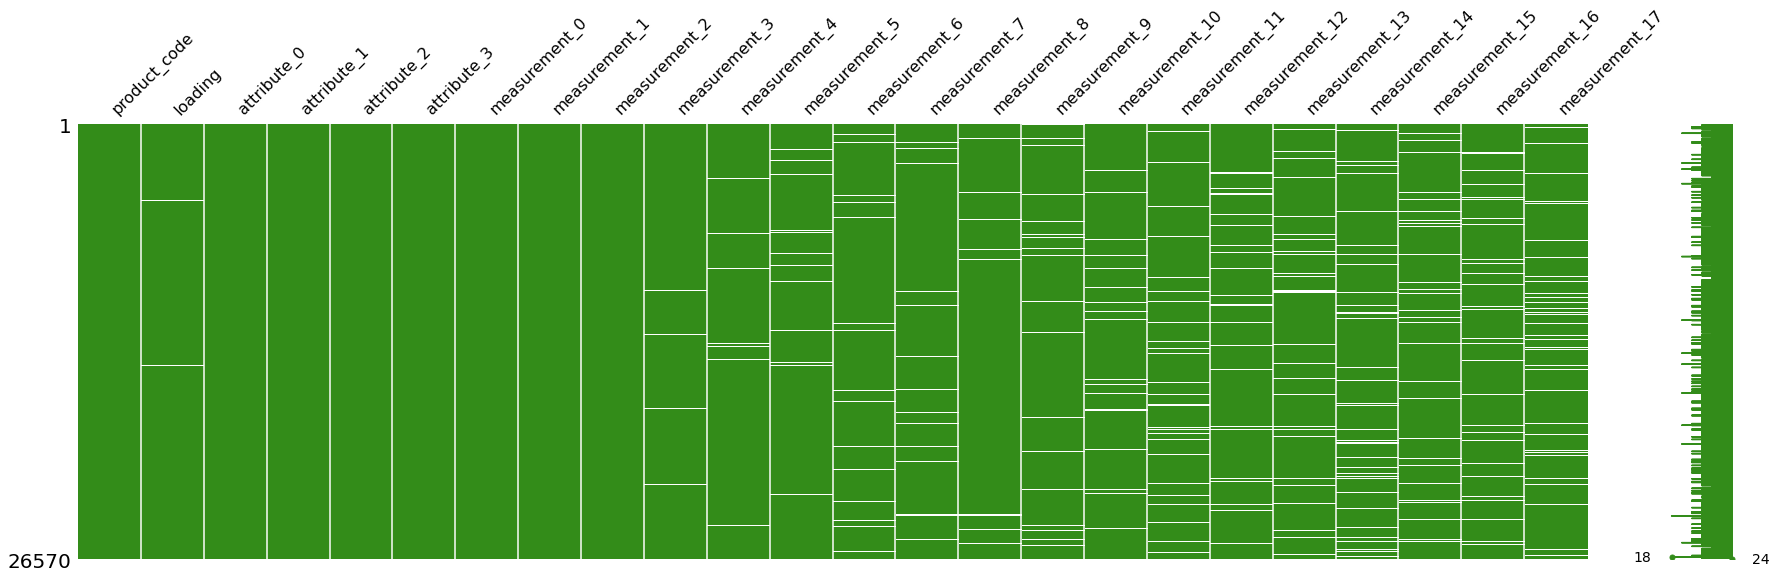

In [37]:
# Train Null Values
msno.matrix(train_df[all_features], color=(0.2, 0.55, 0.1), figsize=(30, 8))

# Pre Process

In [38]:
# Concatenate Train,Test
data = pd.concat([train_df[all_features],test_df[all_features]])
data.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885


In [39]:
# Total Null Percentage 
data_missing_percentage = data[cont_columns].isna().any(axis=1).sum() / len(data)
print(f' Total Missing percentage : {round(data_missing_percentage,2)} %',end='')

 Total Missing percentage : 0.54 %

In [40]:
data.shape

(47345, 24)

In [41]:
# Product Categories
product_types = train_df['product_code'].unique().tolist() + test_df['product_code'].unique().tolist()
product_types

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

In [42]:
# Measurments
measurments = [col for col in data.columns if str(data[col].name).startswith('m')]
measurments

['measurement_0',
 'measurement_1',
 'measurement_2',
 'measurement_3',
 'measurement_4',
 'measurement_5',
 'measurement_6',
 'measurement_7',
 'measurement_8',
 'measurement_9',
 'measurement_10',
 'measurement_11',
 'measurement_12',
 'measurement_13',
 'measurement_14',
 'measurement_15',
 'measurement_16',
 'measurement_17']

In [43]:
measured_data = data[measurments]

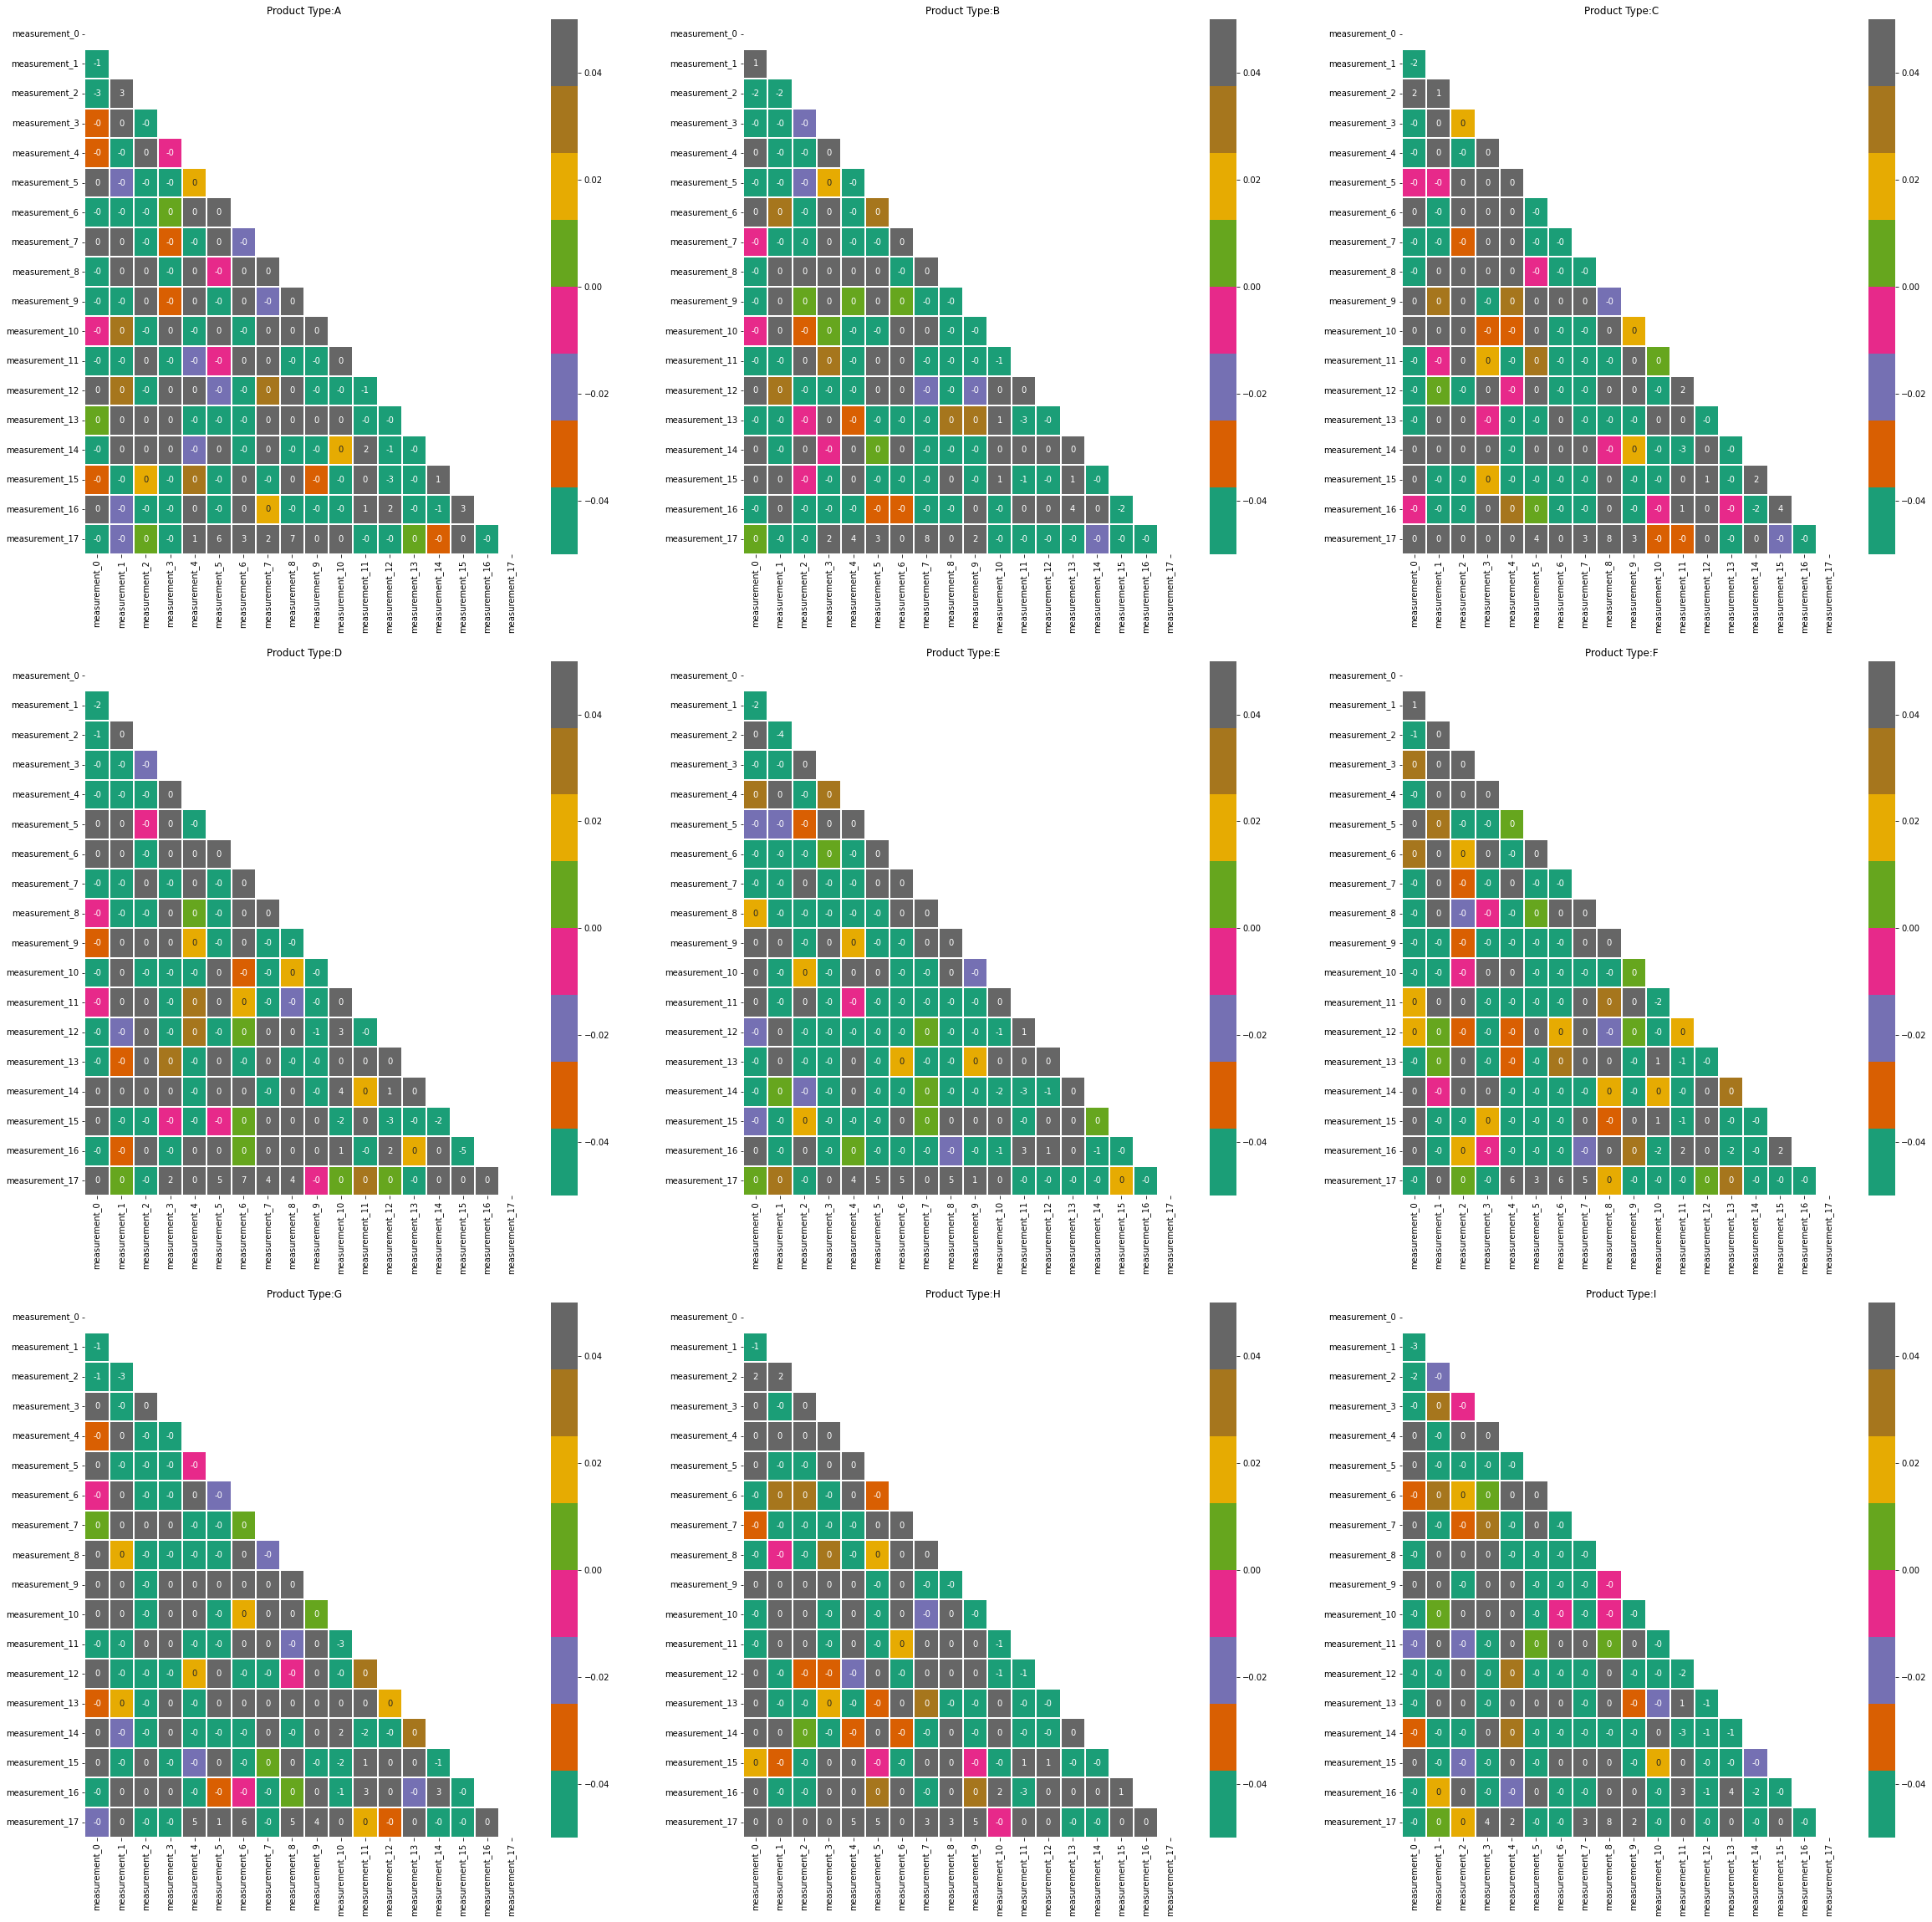

In [44]:
# Measurments Corrlation
fig, axes = plt.subplots(figsize=(40,40))
for  n, p_type in enumerate(product_types):
    plt.subplot(3,3,n+1)
    matrix = np.triu(measured_data.loc[data['product_code'] == str(p_type)].corr())
    sns.heatmap(measured_data.loc[data['product_code'] == str(p_type)].corr() *10 , annot= True , cmap="Dark2" , mask=matrix , linecolor="white" ,cbar=True ,vmin= - 0.05 ,fmt='.0f' , vmax= 0.05 ,linewidths=0.1)
    plt.title("Product Type:" + str(p_type))
plt.show()

In [45]:
measurment_missings = pd.concat([data.isna().sum().rename('missing values in train'),
           round(data.isna().sum() / len(data) * 100,2).rename("Missin Rate Train")],
          axis=1)
measurment_missings

,missing values in train,Missin Rate Train
product_code,0,0.0
loading,473,1.0
attribute_0,0,0.0
attribute_1,0,0.0
attribute_2,0,0.0
attribute_3,0,0.0
measurement_0,0,0.0
measurement_1,0,0.0
measurement_2,0,0.0
measurement_3,710,1.5


Text(0.5, 1.0, 'Heatmap of missing values')

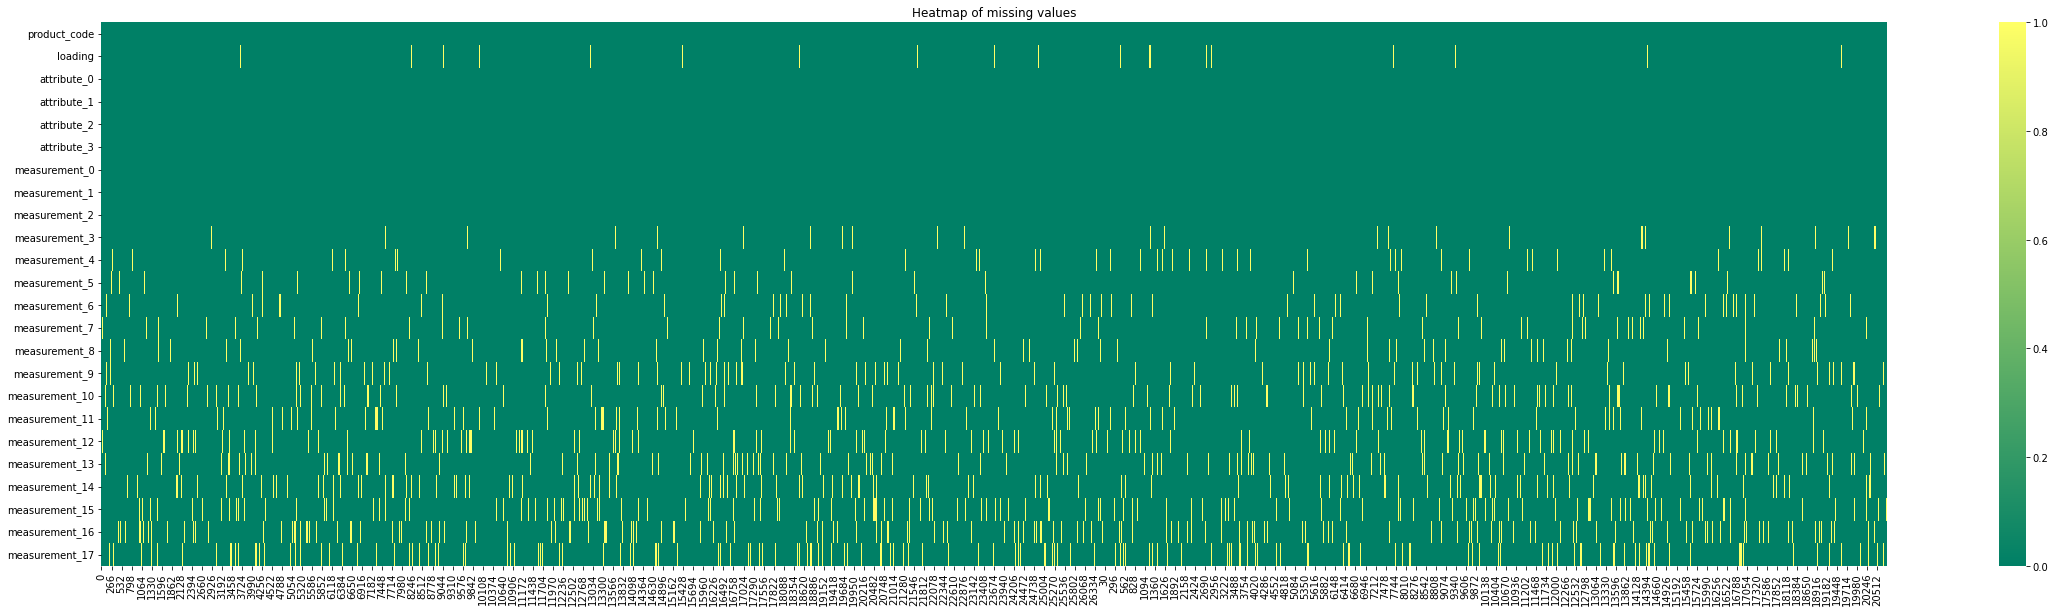

In [46]:
# Total Null Heatmap
plt.figure(figsize=(40,10))
sns.heatmap(data.isna().T, cmap='summer')
plt.title('Heatmap of missing values')

feature           fail   miss   failure rate       z    p-value
loading         :   44 /  250 = 0.176          -1.41      0.157
measurement_3   :   61 /  381 = 0.160          -2.50      0.012
measurement_4   :  128 /  538 = 0.238           1.43      0.151
measurement_5   :  172 /  676 = 0.254           2.66      0.008
measurement_6   :  171 /  796 = 0.215           0.15      0.879
measurement_7   :  197 /  937 = 0.210          -0.18      0.860
measurement_8   :  218 / 1048 = 0.208          -0.36      0.716
measurement_9   :  283 / 1227 = 0.231           1.54      0.123
measurement_10  :  277 / 1300 = 0.213           0.04      0.967
measurement_11  :  311 / 1468 = 0.212          -0.07      0.944
measurement_12  :  356 / 1601 = 0.222           0.95      0.340
measurement_13  :  373 / 1774 = 0.210          -0.24      0.809
measurement_14  :  413 / 1874 = 0.220           0.82      0.411
measurement_15  :  430 / 2009 = 0.214           0.16      0.876
measurement_16  :  436 / 2110 = 0.207   

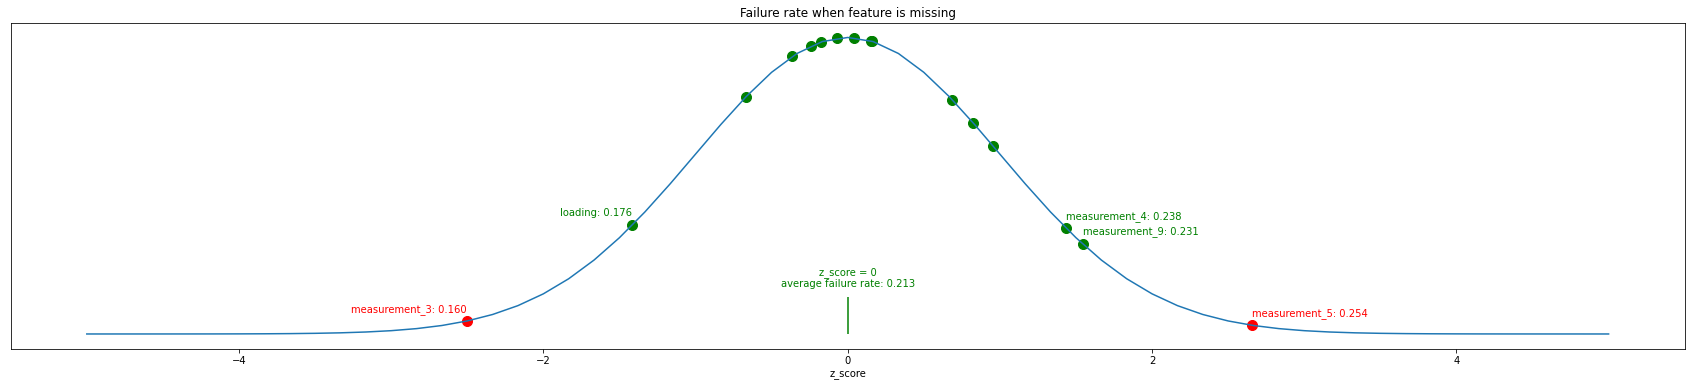

In [47]:
plt.figure(figsize=(30,6))
z_ticks = np.linspace(-5, 5, 61)
pdf = scipy.stats.norm.pdf(z_ticks)
plt.plot(z_ticks, pdf)

# Calculate the conditional failure rate for every missing feature
# Print the values and plot them
print('feature           fail   miss   failure rate       z    p-value')
for f in train_df.columns:
    if train_df[f].isna().sum() > 0:
        total = train_df[f].isna().sum()
        fail = train_df[train_df[f].isna()].failure.sum()
        z = (fail / total - 0.212608) / (np.sqrt(0.212608 * (1-0.212608)) / np.sqrt(total))
        plt.scatter([z], [scipy.stats.norm.pdf(z)], c='r' if abs(z) > 2 else 'g', s=100)
        print(f"{f:15} : {fail:4} / {total:4} = {fail/total:.3f}          {z:5.2f}      {2*scipy.stats.norm.cdf(-abs(z)):.3f}")
        if abs(z) > 1: plt.annotate(f"{f}: {fail / total:.3f}",
                                    (z, scipy.stats.norm.pdf(z)),
                                    xytext=(0,10), 
                                    textcoords='offset points', ha='left' if z > 0 else 'right',
                                    color='r' if abs(z) > 2 else 'g')
            
# Annotage the center (z=0)
plt.vlines([0], 0, 0.05, color='g')
plt.annotate(f"z_score = 0\naverage failure rate: {0.212608:.3f}",
                                    (0, 0.05),
                                    xytext=(0,10), 
                                    textcoords='offset points', ha='center',
                                    color='g')
plt.title('Failure rate when feature is missing')
plt.yticks([])
plt.xlabel('z_score')
plt.show()

In [48]:
data[obj_columns + ["attribute_2","attribute_3"]].drop_duplicates().set_index("product_code")

,attribute_0,attribute_1,attribute_2,attribute_3
product_code,,,,
A,material_7,material_8,9,5
B,material_5,material_5,8,8
C,material_7,material_8,5,8
D,material_7,material_5,6,6
E,material_7,material_6,6,9
F,material_5,material_6,6,4
G,material_5,material_6,9,7
H,material_7,material_7,7,9
I,material_7,material_5,9,5


In [49]:
train_df["measurment_3_missing"] = train_df.measurement_3.isna()
test_df["measurment_3_missing"] = test_df.measurement_3.isna()

train_df["measurment_5_missing"] = train_df.measurement_5.isna()
test_df["measurment_5_missing"] = test_df.measurement_5.isna()



In [50]:
data["measurment_3_missing"] = data.measurement_3.isna()
data["measurment_5_missing"] = data.measurement_5.isna()
data['A2X3'] = data['attribute_2'] * data['attribute_3']

In [51]:
measurments

['measurement_0',
 'measurement_1',
 'measurement_2',
 'measurement_3',
 'measurement_4',
 'measurement_5',
 'measurement_6',
 'measurement_7',
 'measurement_8',
 'measurement_9',
 'measurement_10',
 'measurement_11',
 'measurement_12',
 'measurement_13',
 'measurement_14',
 'measurement_15',
 'measurement_16',
 'measurement_17']

In [52]:
measurments.insert(0,'loading')

In [53]:
data=pd.get_dummies(data)

In [54]:
train = data[:train_df.shape[0]]
test = data[train_df.shape[0]:]

In [55]:
all_features = data.columns

In [56]:
imputer = LGBMImputer(n_iter=100)

for each in product_types:
    temp = data[data[f"product_code_{each}"]==1]
    temp = pd.DataFrame(data=imputer.fit_transform(temp),columns= all_features)
    data.iloc[data[f"product_code_{each}"]==1] = temp
    print(f'Data Imputed base on Product Type {each}\n')

  0%|          | 0/16 [00:00<?, ?it/s]

Data Imputed base on Product Type A



  0%|          | 0/16 [00:00<?, ?it/s]

Data Imputed base on Product Type B



  0%|          | 0/16 [00:00<?, ?it/s]

Data Imputed base on Product Type C



  0%|          | 0/16 [00:00<?, ?it/s]

Data Imputed base on Product Type D



  0%|          | 0/16 [00:00<?, ?it/s]

Data Imputed base on Product Type E



  0%|          | 0/16 [00:00<?, ?it/s]

Data Imputed base on Product Type F



  0%|          | 0/16 [00:00<?, ?it/s]

Data Imputed base on Product Type G



  0%|          | 0/16 [00:00<?, ?it/s]

Data Imputed base on Product Type H



  0%|          | 0/16 [00:00<?, ?it/s]

Data Imputed base on Product Type I



Text(0.5, 1.0, 'Heatmap of missing values')

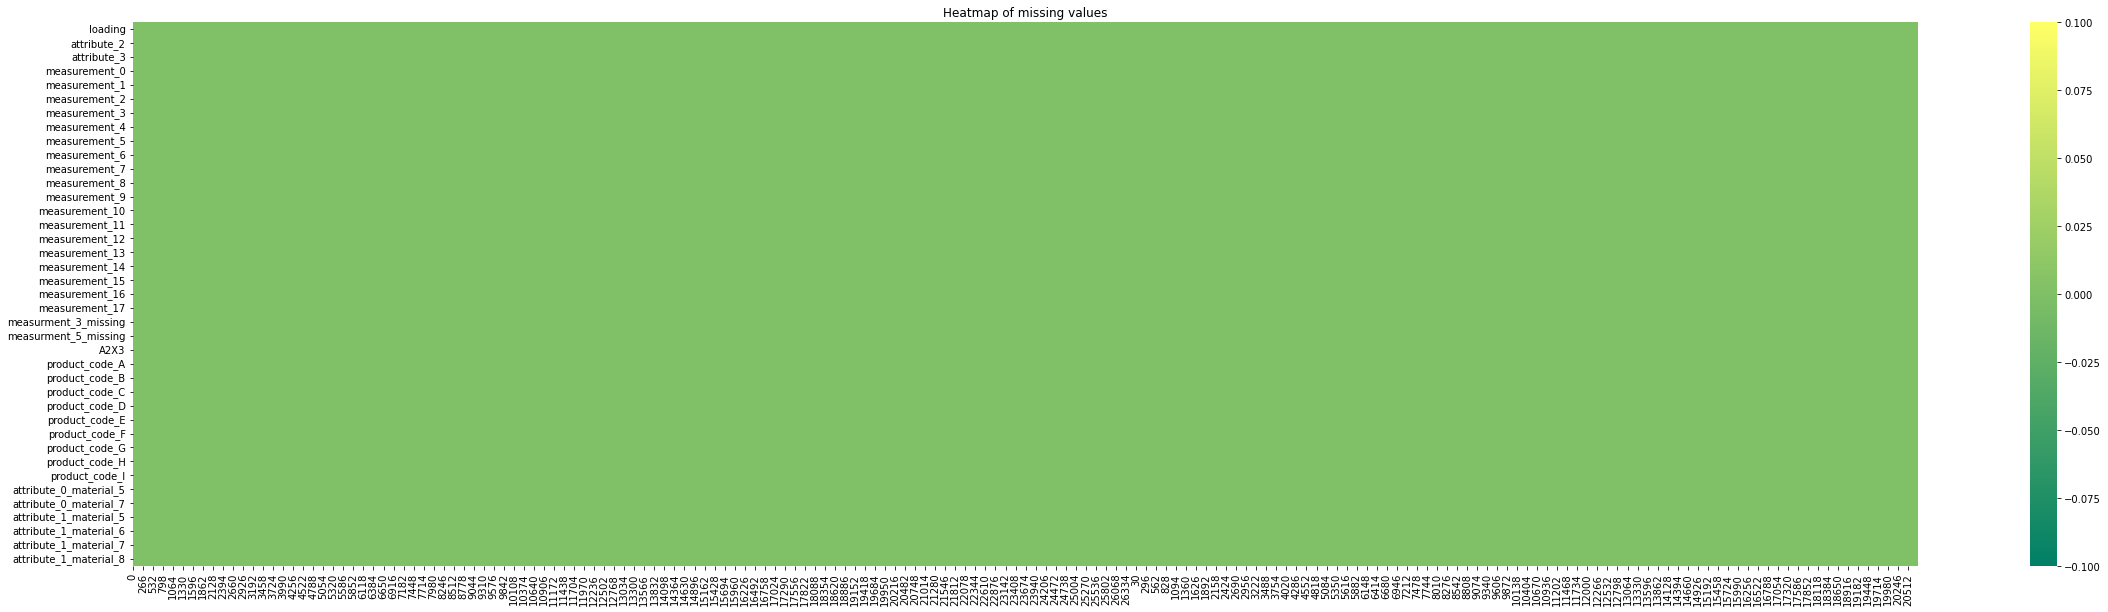

In [57]:
plt.figure(figsize=(40,10))
sns.heatmap(data.isna().T, cmap='summer')
plt.title('Heatmap of missing values')

In [58]:
data.head()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,product_code_F,product_code_G,product_code_H,product_code_I,attribute_0_material_5,attribute_0_material_7,attribute_1_material_5,attribute_1_material_6,attribute_1_material_7,attribute_1_material_8
0,80.10,9,5,7,8,4,18.040,12.518,15.748,19.292,...,0,0,0,0,0,1,0,0,0,1
1,84.89,9,5,14,3,3,18.213,11.540,17.717,17.893,...,0,0,0,0,0,1,0,0,0,1
2,82.43,9,5,12,1,5,18.057,11.652,16.738,18.240,...,0,0,0,0,0,1,0,0,0,1
3,101.07,9,5,13,2,6,17.295,11.188,18.576,18.339,...,0,0,0,0,0,1,0,0,0,1
4,188.06,9,5,9,2,8,19.346,12.950,16.990,15.746,...,0,0,0,0,0,1,0,0,0,1


In [59]:
cat_columns = get_categorical_columns(data)
cat_columns

 There are 21 categorical columns in Dataframe['attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'A2X3', 'product_code_A', 'product_code_B', 'product_code_C', 'product_code_D', 'product_code_E', 'product_code_F', 'product_code_G', 'product_code_H', 'product_code_I', 'attribute_0_material_5', 'attribute_0_material_7', 'attribute_1_material_5', 'attribute_1_material_6', 'attribute_1_material_7', 'attribute_1_material_8']



['attribute_2',
 'attribute_3',
 'measurement_0',
 'measurement_1',
 'measurement_2',
 'A2X3',
 'product_code_A',
 'product_code_B',
 'product_code_C',
 'product_code_D',
 'product_code_E',
 'product_code_F',
 'product_code_G',
 'product_code_H',
 'product_code_I',
 'attribute_0_material_5',
 'attribute_0_material_7',
 'attribute_1_material_5',
 'attribute_1_material_6',
 'attribute_1_material_7',
 'attribute_1_material_8']

In [60]:
cont_columns = get_continuous_columns(data)

There are 16 continous  columns  in Datframe
['loading', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']



In [61]:
obj_columns = get_object_columns(data)
obj_columns

 There are 0 Objective columns in Dataframe[]



[]

In [62]:
standard_scaler = StandardScaler()
data[all_features] = standard_scaler.fit_transform(data[all_features])

In [63]:
data.head()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,product_code_F,product_code_G,product_code_H,product_code_I,attribute_0_material_5,attribute_0_material_7,attribute_1_material_5,attribute_1_material_6,attribute_1_material_7,attribute_1_material_8
0,-1.224719,1.223359,-1.01701,-0.103287,-0.129328,-0.619559,0.256116,0.800369,-1.373960,1.808101,...,-0.359628,-0.347721,-0.344316,-0.352321,-0.707017,0.707017,-0.700676,-0.710145,-0.344316,1.832367
1,-1.101584,1.223359,-1.01701,1.568709,-1.299094,-0.901217,0.429629,-0.180140,0.598139,0.398955,...,-0.359628,-0.347721,-0.344316,-0.352321,-0.707017,0.707017,-0.700676,-0.710145,-0.344316,1.832367
2,-1.164823,1.223359,-1.01701,1.090996,-1.767000,-0.337901,0.273167,-0.067852,-0.382402,0.748471,...,-0.359628,-0.347721,-0.344316,-0.352321,-0.707017,0.707017,-0.700676,-0.710145,-0.344316,1.832367
3,-0.685647,1.223359,-1.01701,1.329853,-1.533047,-0.056242,-0.491090,-0.533042,1.458490,0.848189,...,-0.359628,-0.347721,-0.344316,-0.352321,-0.707017,0.707017,-0.700676,-0.710145,-0.344316,1.832367
4,1.550589,1.223359,-1.01701,0.374426,-1.533047,0.507074,1.565984,1.233477,-0.130006,-1.763617,...,-0.359628,-0.347721,-0.344316,-0.352321,-0.707017,0.707017,-0.700676,-0.710145,-0.344316,1.832367


In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47345 entries, 0 to 20774
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   loading                 47345 non-null  float64
 1   attribute_2             47345 non-null  float64
 2   attribute_3             47345 non-null  float64
 3   measurement_0           47345 non-null  float64
 4   measurement_1           47345 non-null  float64
 5   measurement_2           47345 non-null  float64
 6   measurement_3           47345 non-null  float64
 7   measurement_4           47345 non-null  float64
 8   measurement_5           47345 non-null  float64
 9   measurement_6           47345 non-null  float64
 10  measurement_7           47345 non-null  float64
 11  measurement_8           47345 non-null  float64
 12  measurement_9           47345 non-null  float64
 13  measurement_10          47345 non-null  float64
 14  measurement_11          47345 non-null

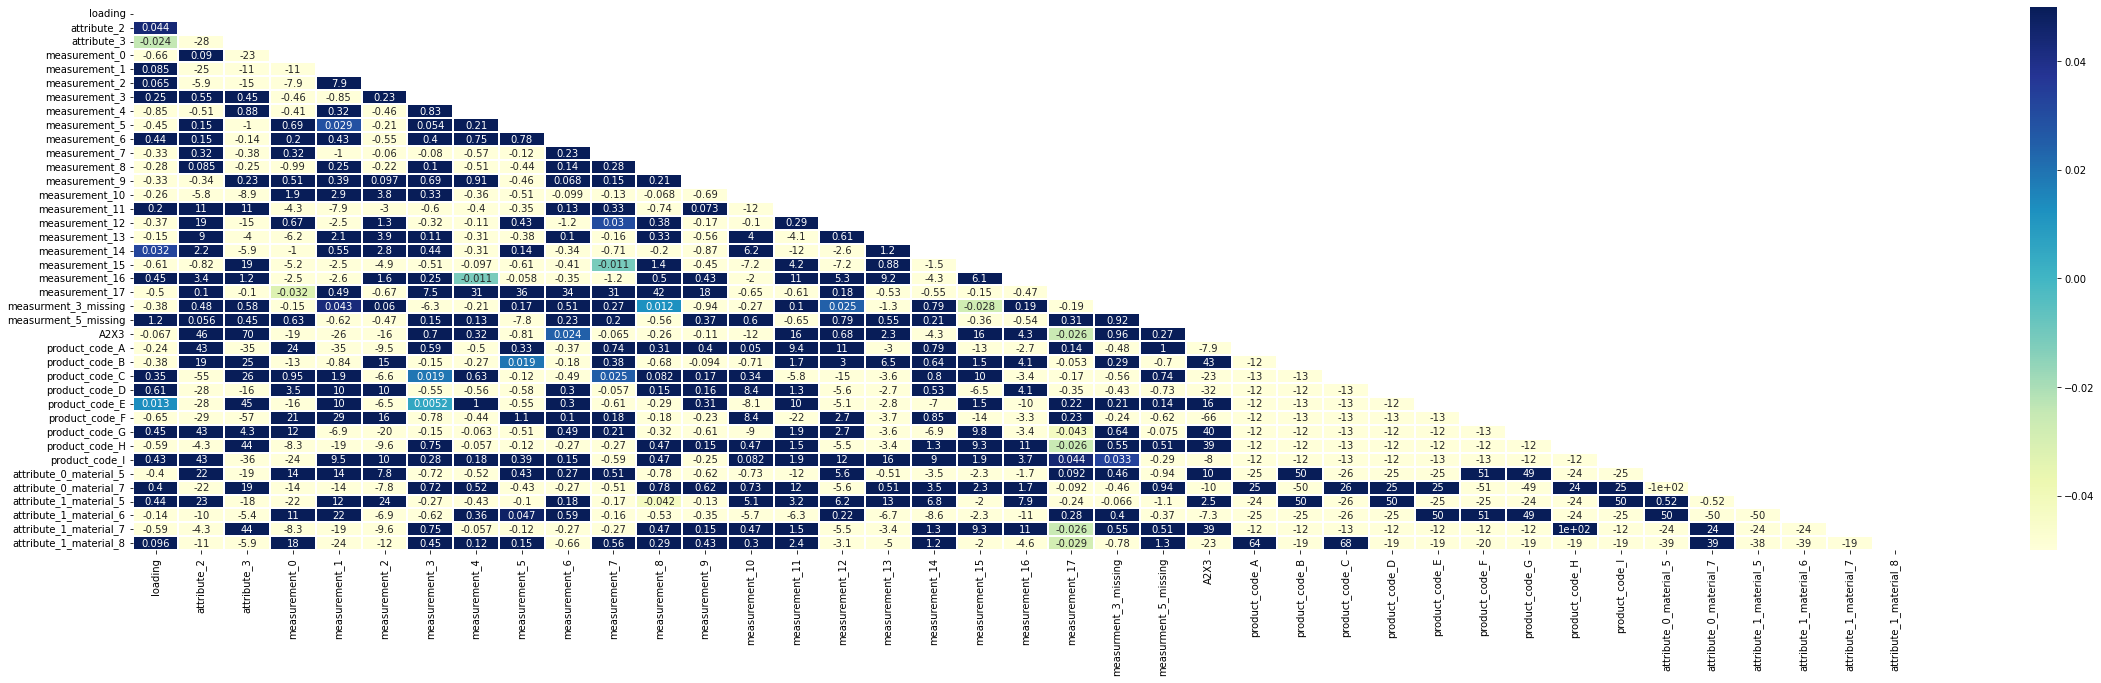

In [65]:
# All Feautre Corr
matrix = np.triu(data.corr())
plt.figure(figsize=(40 ,10))
sns.heatmap(data.corr() * 100 , annot= True , cmap="YlGnBu" , mask=matrix , linecolor="white" ,cbar=True ,vmin= - 0.05  , vmax= 0.05 ,linewidths=0.1)
plt.show()

In [66]:
usefull_feauters = data.columns[:23]
usefull_feauters

Index(['loading', 'attribute_2', 'attribute_3', 'measurement_0',
       'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4',
       'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8',
       'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12',
       'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16',
       'measurement_17', 'measurment_3_missing', 'measurment_5_missing'],
      dtype='object')

In [67]:
data = data[usefull_feauters]
data.head()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,measurment_3_missing,measurment_5_missing
0,-1.224719,1.223359,-1.01701,-0.103287,-0.129328,-0.619559,0.256116,0.800369,-1.373960,1.808101,...,-0.162397,-0.916140,2.424331,-0.513332,-1.734793,-1.300872,-1.101832,0.496207,-0.123388,-0.160154
1,-1.101584,1.223359,-1.01701,1.568709,-1.299094,-0.901217,0.429629,-0.180140,0.598139,0.398955,...,1.271906,-0.707184,-0.006337,-0.755709,-0.434753,-0.405057,-0.526597,-0.155365,-0.123388,-0.160154
2,-1.164823,1.223359,-1.01701,1.090996,-1.767000,-0.337901,0.273167,-0.067852,-0.382402,0.748471,...,-0.335502,0.161680,1.438065,0.859320,1.809856,-0.603176,0.879601,-0.303726,-0.123388,-0.160154
3,-0.685647,1.223359,-1.01701,1.329853,-1.533047,-0.056242,-0.491090,-0.533042,1.458490,0.848189,...,0.172136,-0.406445,-1.232983,-0.332978,-0.338836,0.752724,0.409451,0.990046,-0.123388,-0.160154
4,1.550589,1.223359,-1.01701,0.374426,-1.533047,0.507074,1.565984,1.233477,-0.130006,-1.763617,...,0.677714,0.605785,0.469475,0.427612,-2.300594,-1.222545,-0.052195,-0.966798,-0.123388,-0.160154


In [68]:
train = data[:train_df.shape[0]]
test = data[train_df.shape[0]:]

In [69]:
X = train
y = train_df.failure

In [70]:
# Logistic Regression
result_0 = []
result_1 = []
for step,cross_val in enumerate([StratifiedKFold(n_splits=5, shuffle=True, random_state=0),GroupKFold(n_splits=5)]) :
    print(f'\n******** cross validation strategy : {cross_val} ********\n')
    lr_oof = np.zeros(len(train))
    lr_test = np.zeros(len(test))
    lr_auc = 0
    importance_list = []
    
    kf = cross_val
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y,groups = train.measurement_17 )):
        x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        #x_train, x_val, x_test = _scale(x_train, x_val, test, select_feature)

        model = LogisticRegression(max_iter=100, C=0.0001, penalty='l2', solver='saga')
        model.fit(x_train[usefull_feauters], y_train)
        importance_list.append(model.coef_.ravel())

        val_preds = model.predict_proba(x_val[usefull_feauters])[:, 1]
        print("FOLD: ", fold_idx+1, " ROC-AUC:", round(roc_auc_score(y_val, val_preds), 5))
        lr_auc += roc_auc_score(y_val, val_preds) / 5
        lr_test += model.predict_proba(test[usefull_feauters])[:, 1] / 5
        lr_oof[val_idx] = val_preds
    
    if step == 0:
        result_0 = lr_test
    else:
        result_1 = lr_test
    print(f"\n{Fore.GREEN}{Style.BRIGHT}Average auc = {round(lr_auc, 5)}{Style.RESET_ALL}")
    print(f"{Fore.BLUE}{Style.BRIGHT}OOF auc     = {round(roc_auc_score(y, lr_oof), 5)}{Style.RESET_ALL}\n")


******** cross validation strategy : StratifiedKFold(n_splits=5, random_state=0, shuffle=True) ********

FOLD:  1  ROC-AUC: 0.59561
FOLD:  2  ROC-AUC: 0.59292
FOLD:  3  ROC-AUC: 0.58117
FOLD:  4  ROC-AUC: 0.59182
FOLD:  5  ROC-AUC: 0.5843

Average auc = 0.58916
OOF auc     = 0.58907


******** cross validation strategy : GroupKFold(n_splits=5) ********

FOLD:  1  ROC-AUC: 0.58967
FOLD:  2  ROC-AUC: 0.60022
FOLD:  3  ROC-AUC: 0.5814
FOLD:  4  ROC-AUC: 0.59304
FOLD:  5  ROC-AUC: 0.57966

Average auc = 0.5888
OOF auc     = 0.5878



In [71]:
sample_submission = pd.read_csv("/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv")
sample_submission.head()

,id,failure
0,26570,0.0
1,26571,0.0
2,26572,0.0
3,26573,0.0
4,26574,0.0


In [72]:
test = test_df.drop('id', axis = 1)

sub1 = sample_submission.copy()
sub1.failure = result_0
sub1.to_csv('submission.csv', index = False)

In [73]:
sub1.head()

,id,failure
0,26570,0.215315
1,26571,0.202680
2,26572,0.207103
3,26573,0.207425
4,26574,0.248832
